In [2]:
pip install tensorflow

Note: you may need to restart the kernel to use updated packages.


In [3]:
from tensorflow.keras.callbacks import EarlyStopping
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, GlobalAveragePooling2D
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.optimizers import Adam
from skimage.transform import resize
from sklearn.metrics import accuracy_score
import tensorflow as tf
import matplotlib.pyplot as plt

In [4]:

df = pd.read_csv(r'C:\Users\Pranav Desai\Desktop\Chronic Disease\accurate_augmented_heart_data.csv')

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11190 entries, 0 to 11189
Data columns (total 12 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   age                  11190 non-null  int64  
 1   sex                  11190 non-null  int64  
 2   chest pain type      11190 non-null  int64  
 3   resting bp s         11190 non-null  int64  
 4   cholesterol          11190 non-null  int64  
 5   fasting blood sugar  11190 non-null  int64  
 6   resting ecg          11190 non-null  int64  
 7   max heart rate       11190 non-null  int64  
 8   exercise angina      11190 non-null  int64  
 9   oldpeak              11190 non-null  float64
 10  ST slope             11190 non-null  int64  
 11  target               11190 non-null  int64  
dtypes: float64(1), int64(11)
memory usage: 1.0 MB


In [6]:
x = df.drop('target', axis=1)
y = df['target']

In [7]:
# Normalize the input features
scaler = StandardScaler()
x_scaled = scaler.fit_transform(x)

In [8]:
# Convert tabular rows to image
def tabular_to_image(x_row, img_size=224):
    side = int(np.ceil(np.sqrt(x_row.shape[0])))
    padded = np.pad(x_row, (0, side*side - x_row.shape[0]), mode='constant')
    image = padded.reshape(side, side)
    image = np.stack([image]*3, axis=-1)
    image_resized = resize(image, (img_size, img_size), mode='reflect', anti_aliasing=True)
    return image_resized

x_images = np.array([tabular_to_image(x) for x in x_scaled])


In [9]:
x_train, x_test, y_train, y_test = train_test_split(x_images, y, test_size=0.2, random_state=42)


In [10]:
#Build EfficientNet Model
base_model = EfficientNetB0(include_top=False, input_shape=(224, 224, 3), weights='imagenet')
base_model.trainable = False  # Freeze base layers

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(64, activation='relu')(x)
output = Dense(1, activation='sigmoid')(x)

model = Model(inputs=base_model.input, outputs=output)
model.compile(optimizer=Adam(), loss='binary_crossentropy', metrics=['accuracy'])


16719872/16705208 [==============================] - 3s 0us/step


In [11]:
early_stop = EarlyStopping(
    monitor='val_loss',
    patience=3,
    restore_best_weights=True,
    verbose=1
)

In [12]:
history = model.fit(x_train, y_train, epochs=30, batch_size=32, validation_split=0.2,
    callbacks=[early_stop])

Epoch 1/30
224/224 [==============================] - 27s 72ms/step - loss: 0.6937 - accuracy: 0.5163 - val_loss: 0.6909 - val_accuracy: 0.5349
Epoch 2/30
224/224 [==============================] - 13s 59ms/step - loss: 0.6922 - accuracy: 0.5256 - val_loss: 0.6908 - val_accuracy: 0.5349
Epoch 3/30
224/224 [==============================] - 13s 60ms/step - loss: 0.6920 - accuracy: 0.5251 - val_loss: 0.6908 - val_accuracy: 0.5349
Epoch 4/30
224/224 [==============================] - 13s 60ms/step - loss: 0.6922 - accuracy: 0.5251 - val_loss: 0.6914 - val_accuracy: 0.5349
Epoch 5/30
224/224 [==============================] - 13s 60ms/step - loss: 0.6920 - accuracy: 0.5251 - val_loss: 0.6909 - val_accuracy: 0.5349
Epoch 6/30
224/224 [==============================] - 13s 60ms/step - loss: 0.6918 - accuracy: 0.5251 - val_loss: 0.6909 - val_accuracy: 0.5349
Restoring model weights from the end of the best epoch.
Epoch 00006: early stopping


In [13]:
history = model.fit(x_train, y_train, epochs=30, batch_size=32, validation_split=0.2)

Epoch 1/30
224/224 [==============================] - 14s 63ms/step - loss: 0.6920 - accuracy: 0.5251 - val_loss: 0.6919 - val_accuracy: 0.5349
Epoch 2/30
224/224 [==============================] - 13s 60ms/step - loss: 0.6923 - accuracy: 0.5251 - val_loss: 0.6910 - val_accuracy: 0.5349
Epoch 3/30
224/224 [==============================] - 13s 60ms/step - loss: 0.6921 - accuracy: 0.5251 - val_loss: 0.6910 - val_accuracy: 0.5349
Epoch 4/30
224/224 [==============================] - 14s 61ms/step - loss: 0.6920 - accuracy: 0.5251 - val_loss: 0.6912 - val_accuracy: 0.5349s: 0.692
Epoch 5/30
224/224 [==============================] - 13s 59ms/step - loss: 0.6921 - accuracy: 0.5251 - val_loss: 0.6908 - val_accuracy: 0.5349s: 0.6932 - accura - ETA: 8s - ETA: 6s - loss: 0.6924 - ac - ETA:  - ETA - ETA
Epoch 6/30
224/224 [==============================] - 13s 60ms/step - loss: 0.6921 - accuracy: 0.5251 - val_loss: 0.6910 - val_accuracy: 0.5349oss: 0.6921 - accuracy: 0. - ETA: 0s - loss: 0.6921

In [14]:
# 🧪 Evaluate
y_pred = (model.predict(x_test) > 0.5).astype("int32")
print("Test Accuracy:", accuracy_score(y_test, y_pred))


Test Accuracy: 0.5335120643431636


In [15]:
# Extract values from history
loss = history.history['loss']
val_loss = history.history['val_loss']
accuracy = history.history.get('accuracy', history.history.get('acc'))  # Some versions use 'acc'
val_accuracy = history.history.get('val_accuracy', history.history.get('val_acc'))

epochs = range(1, len(loss) + 1)


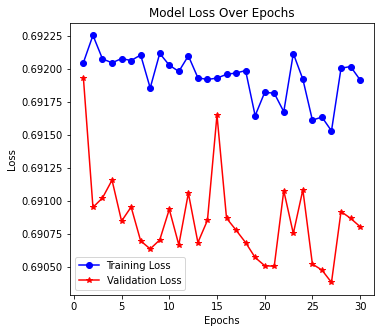

In [16]:
# Plot Loss
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(epochs, loss, 'bo-', label='Training Loss')
plt.plot(epochs, val_loss, 'r*-', label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Model Loss Over Epochs')
plt.legend()

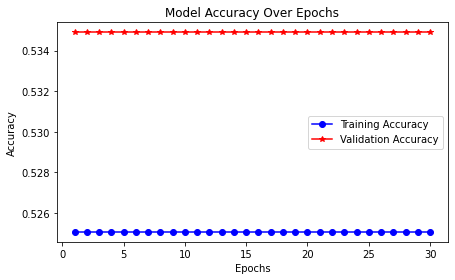

In [17]:
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 2)
plt.plot(epochs, accuracy, 'bo-', label='Training Accuracy')
plt.plot(epochs, val_accuracy, 'r*-', label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Model Accuracy Over Epochs')
plt.legend()

plt.tight_layout()
plt.show()

In [18]:
import tensorflow as tf
import os
import time
from tensorflow.python.framework.convert_to_constants import convert_variables_to_constants_v2
from tensorflow.python.profiler import model_analyzer
from tensorflow.python.profiler.option_builder import ProfileOptionBuilder

def evaluate_model_metrics(model, x_test, y_test, model_name="model_metrics"):
    results = {}

    # Total Parameters
    results['total_parameters'] = model.count_params()

    # FLOPs Calculation
    func = tf.function(lambda x: model(x))
    concrete_func = func.get_concrete_function(
        tf.TensorSpec([1] + list(model.input_shape[1:]), model.inputs[0].dtype)
    )
    frozen_func = convert_variables_to_constants_v2(concrete_func)
    flops = model_analyzer.profile(
        graph=frozen_func.graph,
        options=ProfileOptionBuilder.float_operation()
    ).total_float_ops
    results['FLOPs'] = flops
    results['GFLOPs'] = flops / 1e9

    # Model Size
    model_path = f"{model_name}.h5"
    model.save(model_path)
    size_bytes = os.path.getsize(model_path)
    results['model_size_bytes'] = size_bytes
    results['model_size_MB'] = size_bytes / (1024 * 1024)

    # Inference Time
    start = time.time()
    model.predict(x_test)
    end = time.time()
    results['inference_time_seconds'] = end - start

    # Accuracy
    loss, acc = model.evaluate(x_test, y_test, verbose=0)
    results['accuracy'] = acc

    return results
evaluate_model_metrics(model, x_test, y_test, model_name="model_metrics")

Instructions for updating:
Use `tf.compat.v1.graph_util.tensor_shape_from_node_def_name`


d:\Python\lib\site-packages\keras\utils\generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


{'total_parameters': 4131620,
 'FLOPs': 780528156,
 'GFLOPs': 0.780528156,
 'model_size_bytes': 17849544,
 'model_size_MB': 17.02265167236328,
 'inference_time_seconds': 3.9868898391723633,
 'accuracy': 0.5335120558738708}